[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/046_cv_loc/cv_loc.ipynb)

# Localización

En el [post](https://sensioai.com/blog/045_cv_tareas) anterior hablamos de diferentes tareas que podemos llevar a cabo con `redes neuronales` en el campo del visión artificial. Alguno ejemplos son la clasificación de imágenes, la detección de objetos, etc. En este post vamos a ver como llevar a cabo la tarea de localización, que consiste en detectar el objeto principal en una imagen.

## El dataset

En la mayoría de ejemplos con los que hemos trabajado hasta ahora nuestro dataset estaba compuesto por un conjunto de imágenes, cada una de las cuales viene acompañada por una etiqueta. Esto nos ha permitido llevar a cabo tareas de clasificación. Sin embargo, para la tarea de localización, no necesitamos un etiqueta sino las "coordenadas" del objeto dentro de la imagen, su posición exacta. Esta posición la definiremos mediante una caja, cuatro valores que nos permitirán localizar el objeto. Para ello usaremos un dataset creado para la detección de objetos: el dataset [VOC](http://host.robots.ox.ac.uk/pascal/VOC/). 

In [1]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [2]:
train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar


5717

Este dataset contiene imágenes comunes, y en cada una de estas imágenes pueden aparecer un número indeterminado de objetos. Para cada objeto tenemos asignada una caja y su correspondiente etiqueta.

In [3]:
classes = ["background",
            "aeroplane",
            "bicycle",
            "bird",
            "boat",
            "bottle",
            "bus",
            "car",
            "cat",
            "chair",
            "cow",
            "diningtable",
            "dog",
            "horse",
            "motorbike",
            "person",
            "pottedplant",
            "sheep",
            "sofa",
            "train",
            "tvmonitor"]

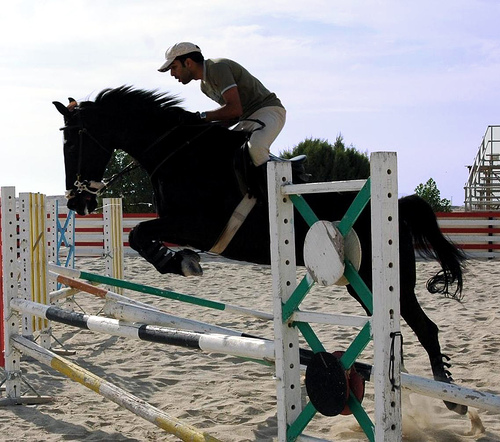

In [4]:
img, label = train[0]
img

In [5]:
label

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

Como puedes observar, ahora nuestras anotaciones son un poco más complicada que una simple etiqueta. Para cada imagen tenemos un `dict` con las anotaciones en el campo `object`, que como puedes ver es una lista con la clase en el campo `name` y las caja en el campo `bndbox`. Las siguientes funciones son útiles para extraer estas anotaciones en un formato adecuado y hacer la visualización de la imagen junto a las anotaciones.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

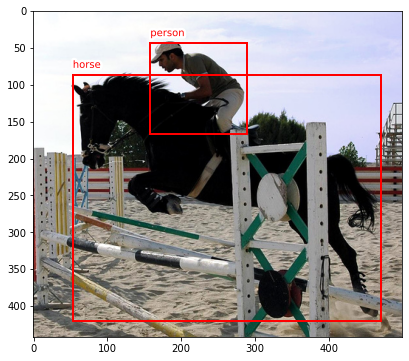

In [7]:
img_np, anns = get_sample(0)
plot_anns(img_np, anns)
plt.show()

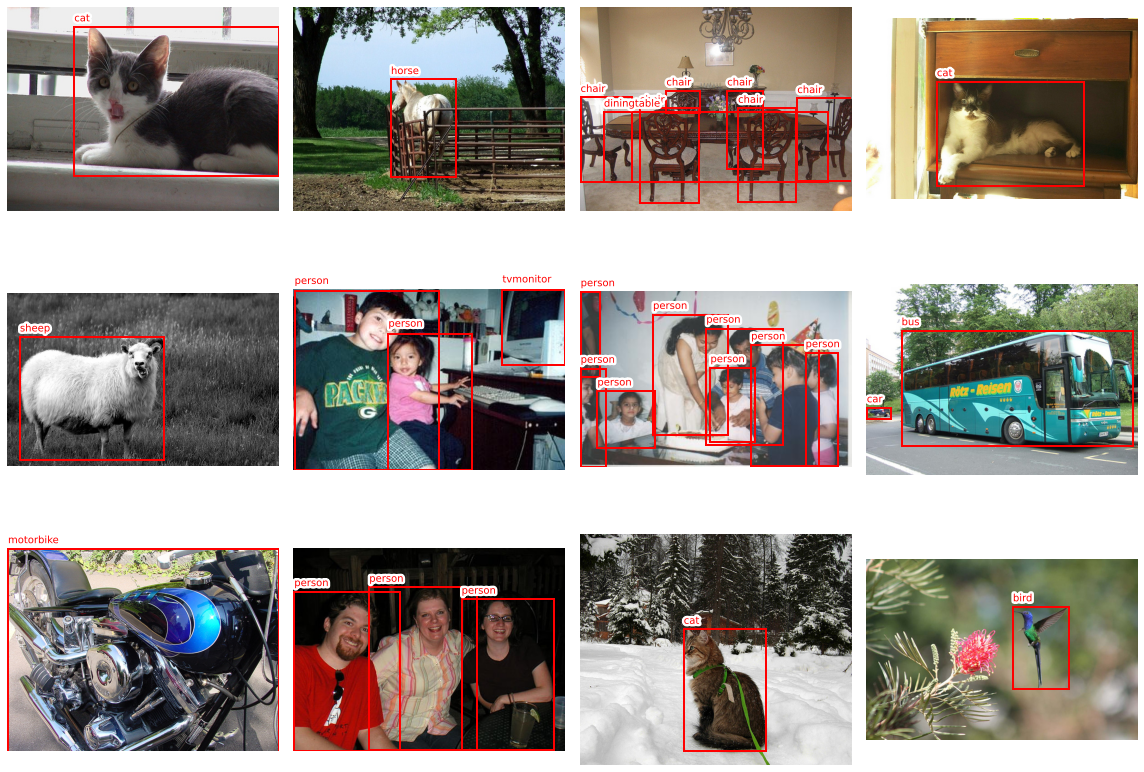

In [8]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

En este dataset encontramos imágenes co nun sólo objeto o muchos objetos, con objetos grandes o objetos pequeños (o ambos), con objetos de la misma clase o diferentes en diferentes parte de la imagen... Como puedes ver existe una gran variabilidad, que hace que el problema de la detección de objetos sea una de las tareas más complejas en el mundo de la visión artificial. Por ahora, nuestro objetivo es solo localizar un objeto en la imagen, y para hacernos la vida más fácil vamos a utilizar una sola imagen con un sólo objeto.

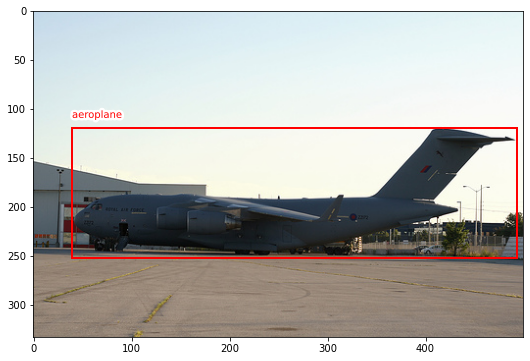

In [9]:
img_np, anns = get_sample(4445)
plot_anns(img_np, anns)
plt.show()

In [10]:
anns

(array([1]), array([[ 39, 119, 454, 133]]))

## El modelo

Para poder llevar a cabo la tarea de localización, vamos a tener que diseñar una red neuronal capaz de recibir una imagen y darnos a la salida una caja. Para trabajar con imágenes ya sabes que utilizar `redes neuronal convolucionales` es la opción correcta, así que simplemente usaremos una CNN con una capa lineal que conecte la salida de la red convolucional a 4 valores. Entonces nuestra tarea consistirá en hacer `regresión` a estos 4 valores, a diferencia de la `clasificación` que hemos hecho en posts anteriores. 

In [11]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class Model(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=4):
    super().__init__()
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16, 32)
    self.conv4 = block(32, 64)
    self.fc1 = block2(64*6*6, 100)
    self.fc2 = torch.nn.Linear(100, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [12]:
model = Model()
output = model(torch.randn(64, 3, 100, 100))
output.shape

torch.Size([64, 4])

## Fit de una muestra

Durante el entrenamiento queremos que la salida de la red coincida con la caja que tenemos en las anotaciones del dataset, de esta manera nuestro modelo aprenderá a predecir cajas alrededor de objetos. En primer lugar haremos un *resize* de la imagen para que tenga unas dimensiones de 100 x 100 (la CNN ha sido diseñada para esta resolución). En el caso de la clasificación de imágenes, transformar la imagen no tiene impacto en la etiqueta. Ahora, sin embargo, dependiendo de la transformación, nuestras etiquetas pueden variar. Las cajas pueden cambiar de dimensiones, ser rotadas e incluso algunas pueden desaparecer (por ejemplo, si hacemos un *crop*). Por suerte, la librería `albumentations` se encarga de todo por nosotros.

In [13]:
import albumentations as A

# with coco format the bb is expected in 
# [x_min, y_min, width, height] 
def get_aug(aug, min_area=0., min_visibility=0.):
    return A.Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['labels']})

trans = get_aug([A.Resize(100, 100)])

labels, bbs = anns
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

img.shape, bbs

((100, 100, 3), [(7.8, 35.73573573573574, 90.8, 39.93993993993994)])

Por otro lado, si intentásemos hacer regresión a las coordenadas de la caja nuestra red neuronal tendría problemas ya que puede tomar valores muy grandes. Es por esto que las normalizamos teniendo en cuenta las dimensiones de la imagen, de forma que nuestra red tendrá que predecir valores entre 0 y 1 (una tarea mucho más sencilla).

In [14]:
def norm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

In [15]:
bb = bbs[0]
bb

(7.8, 35.73573573573574, 90.8, 39.93993993993994)

In [16]:
bb_norm = norm(bb, img.shape[:2])
bb_norm

array([0.078     , 0.35735736, 0.908     , 0.3993994 ])

In [17]:
bb_unnorm = unnorm(bb_norm, img.shape[:2])
bb_unnorm

array([ 7.8       , 35.73573574, 90.8       , 39.93993994])

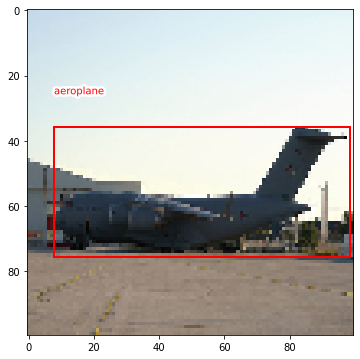

In [18]:
plot_anns(img, (labels, bbs))
plt.show()

Ahora ya podemos intentar hacer el fit de la imagen.

In [19]:
def fit(model, X, y, epochs=1, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.L1Loss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = []
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}")

In [27]:
model = Model()
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0)
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0)
fit(model, img_tensor, bb_tensor, epochs=30)

Epoch 1/30 loss 0.42344
Epoch 2/30 loss 0.38265
Epoch 3/30 loss 0.33241
Epoch 4/30 loss 0.24641
Epoch 5/30 loss 0.23387
Epoch 6/30 loss 0.21353
Epoch 7/30 loss 0.21370
Epoch 8/30 loss 0.16086
Epoch 9/30 loss 0.11926
Epoch 10/30 loss 0.09259
Epoch 11/30 loss 0.06808
Epoch 12/30 loss 0.05235
Epoch 13/30 loss 0.07411
Epoch 14/30 loss 0.07906
Epoch 15/30 loss 0.05251
Epoch 16/30 loss 0.02518
Epoch 17/30 loss 0.03549
Epoch 18/30 loss 0.03219
Epoch 19/30 loss 0.03091
Epoch 20/30 loss 0.05019
Epoch 21/30 loss 0.04707
Epoch 22/30 loss 0.04215
Epoch 23/30 loss 0.04340
Epoch 24/30 loss 0.02576
Epoch 25/30 loss 0.03546
Epoch 26/30 loss 0.02787
Epoch 27/30 loss 0.01715
Epoch 28/30 loss 0.02680
Epoch 29/30 loss 0.01948
Epoch 30/30 loss 0.03434


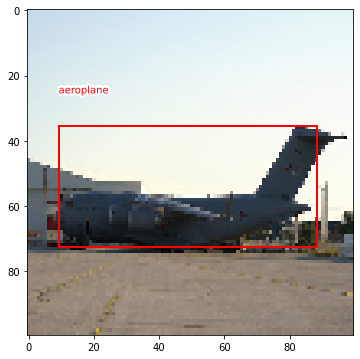

In [28]:
model.eval()
pred_bb_norm = model(img_tensor.to(device))[0].cpu().detach().numpy()
pred_bb = unnorm(pred_bb_norm, img.shape[:2])
plot_anns(img, (anns[0], [pred_bb]))
plt.show()

Si te fijas en el bucle de entrenamiento hemos utilizado una función de pérdida `L1`. Ésta función de pérdida es más suave que la `MSE` (la que hemos utilizado anteriormente para problemas de regresión) y para localización suele funcionar mejor.

En este punto, ¿Te ves capaz de entrenar un modelo de localización para éste dataset? Podrías intentar filtrarlo para quedarte con aquellas muestras que sólo tengan una caja y después implementar un bucle de entrenamiento completo con validación (tienes ejemplos en los posts anteriores). Al tratarse de imágenes naturales, también puedes utilizar una red pre-entrenada y hacer [transfer learning](https://sensioai.com/blog/044_cnn_transfer_learning) (en este caso recuerda hacer el *resize* al mismo tamaño que el de la red original).

## Resumen

En este post hemos visto como llevar a cabo la tarea de localización con `redes neuronales`. Nuestro modelo acepta imágenes a la entrada y a la salida nos da 4 valores: las coordenadas en la imagen de la caja que engloba el objeto de interés. Para ello enfocamos la tarea como un problema de `regresión`. Si bien hemos sido capaces de encontrar estas cajas alrededor de objetos, nuestro modelo no es capaz de decirnos qué objeto es. Esta es la tarea de localización + clasificación, que veremos en el siguiente post.